In [1]:
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import SGDClassifier, LinearRegression
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

from nltk.stem.snowball import SnowballStemmer
from nltk import word_tokenize

import numpy as np

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
from matplotlib.pyplot import plot_date
%matplotlib inline
from ggplot import *
hfont = {'fontname':'Arial'}

import pandas as pd

import re
import pickle

import tweepy
from tweepy import OAuthHandler
import json
import collections

In [217]:
def flatten(d, parent_key='', sep='_'):
    '''
    input: nested dictionary
    output: flattened dictionary
    '''
    
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, collections.MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)


def get_tweet_dataframe(filename):
    '''
    input: filename (of pickle file)
    output: pandas dataframe
    
    function loads pickled array of tweepy status objects, flattens the
    nested json structure, appends these to a temporary array, and then
    creates a dataframe from the array
    '''
    
    tweet_list = []
    timeline_tweets = pickle.load(open(filename, "rb"))
    for tweet in timeline_tweets:
        flat_tweet = flatten(tweet._json)
        entity_hashtag = flat_tweet.pop('entities_hashtags',None)
        if entity_hashtag == []:
            flat_tweet['hashtag'] = []
        else:
            ht_list = []
            for ht in entity_hashtag:
                ht_list.append(ht['text'])
            flat_tweet['hashtag'] = ht_list
        tweet_list.append(flat_tweet)
    tweet_dict = pd.DataFrame(tweet_list)
    return tweet_dict

In [215]:
'''
Get tweets from candidates
'''

(consumer_key, consumer_secret, access_token, access_secret) = pickle.load(open("auth_secrets.p", "rb"))
    
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth)

'''
Initialize arrays of tweets
'''

HC_timeline_tweets = []
DT_timeline_tweets = []

for tweet in tweepy.Cursor(api.user_timeline,id='HillaryClinton').items():
    HC_timeline_tweets.append(tweet)

for tweet in tweepy.Cursor(api.user_timeline,id='realDonaldTrump').items():
    DT_timeline_tweets.append(tweet)

In [216]:
pickle.dump(HC_timeline_tweets, open( "hc_tweets2.p", "wb" ) )
pickle.dump( DT_timeline_tweets, open( "dt_tweets2.p", "wb" ) )

In [222]:
# Create tweet dataframes for each of the candidates

#HCdf = get_tweet_dataframe("hc_tweets.p")
#DTdf = get_tweet_dataframe("dt_tweets.p")
HCdf2 = get_tweet_dataframe("hc_tweets2.p")
DTdf2 = get_tweet_dataframe("dt_tweets2.p")

# Pickle the dataframes

#pickle.dump(HCdf, open('HCdf.p', 'wb'))
#pickle.dump(DTdf, open('DTdf.p', 'wb'))
pickle.dump(HCdf2, open('HCdf2.p', 'wb'))
pickle.dump(DTdf2, open('DTdf2.p', 'wb'))

In [2]:
# Load pickled dataframes
HCdf2 = pickle.load(open('HCdf2.p', 'rb'))
DTdf2 = pickle.load(open('DTdf2.p', 'rb'))

In [3]:
# Create new dataframes with just relevant columns
HC = HCdf2[['text','favorite_count','retweet_count','created_at']]
DT = DTdf2[['text','favorite_count','retweet_count','created_at']]

In [4]:
'''
Add new feature columns to HC, DT dataframes
'''

def hr_func(ts):
    return ts.hour

def day_func(ts):
    return ts.weekday()

def char_length_func(ts):
    return len(ts)

def word_length_func(ts):
    return len(ts.split(' '))

HC.loc[:,'speaker']='HC'
DT.loc[:,'speaker']='DT'

DT.loc[:,'created_at']=pd.to_datetime(DT.loc[:,'created_at'])
HC.loc[:,'created_at']=pd.to_datetime(HC.loc[:,'created_at'])

DT.loc[:,'hour'] = DT.loc[:,'created_at'].apply(hr_func)
HC.loc[:,'hour'] = HC.loc[:,'created_at'].apply(hr_func)

DT.loc[:,'day'] = DT.loc[:,'created_at'].apply(day_func)
HC.loc[:,'day'] = HC.loc[:,'created_at'].apply(day_func)

DT.loc[:,'char_length'] = DT.loc[:,'text'].apply(char_length_func)
HC.loc[:,'char_length'] = HC.loc[:,'text'].apply(char_length_func)

DT.loc[:,'word_length'] = DT.loc[:,'text'].apply(word_length_func)
HC.loc[:,'word_length'] = HC.loc[:,'text'].apply(word_length_func)

/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:461: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [5]:
def clean_tweets(text_array):
    '''
    Function takes out urls, retweets, @users
    '''
    
    edited_array = []
    for tweet in text_array:
        tweet = re.sub('\u\d+',' ',tweet.strip())
        tweet = re.sub(r'http\S*',' ',tweet)
        tweet = re.sub(r'@\S*',' ',tweet)
        tweet = re.sub(r'[rR][tT]',' ',tweet)
        edited_array.append(tweet)
    return edited_array

In [6]:
HC.loc[:,'etext']=clean_tweets(HC['text'])[:]
DT.loc[:,'etext']=clean_tweets(DT['text'])[:]

In [6]:
# Pickle simple dataframes
pickle.dump(HC, open('HC.p', 'wb'))
pickle.dump(DT, open('DT.p', 'wb'))

In [2]:
# Pickle simple dataframes
HC = pickle.load(open('HC.p', 'rb'))
DT = pickle.load(open('DT.p', 'rb'))

In [7]:
HC.head(1)

,text,favorite_count,retweet_count,created_at,speaker,hour,day,char_length,word_length,etext,guncontrol,abortion,immigration,criminal_justice,money,national_defense,climate_change,health_care,higher_education,diversity
0,A great day to hit the campaign trail in Ohio ...,2147,685,2016-06-27 17:18:25,HC,17,0,91,13,A great day to hit the campaign trail in Ohio ...,0,0,0,0,0,0,0,0,0,0


In [4]:
GUN_CONTROL=["gun","assault weapon","semi-automatic","pistol grip","selective fire weapons",
"flash suppressor","high-capacity magazine","strawman purchase","private party transfer",
"federally licensed firearms dealer","gunshow","gunshow loophole","gun control act of 1968",
"firearm owners protection","brady handgun violence prevention","assault weapons ban",
"second ammendment","2nd ammendment","national rifle association"]
ABORTION=["women's right","right to choose","prolife","pro-life",r"roe vs\.? wade",
         r"pro-?choice","planned parenthood"]
IMMIGRATION=["[Mm]exic","[Mm]uslim","refugee","borders","wall","undocumented","birthright citizenship"]
CRIMINAL_JUSTICE=["prison reform","criminal sentencing","steep penalties","non-?violent",
                 "drug offenses","mass incarceration","prison sentence","black lives matter",
                 "police shooting",r"death penalty|penalties"]
MONEY=["money","budget","jobs","middle class", "wages", "economy","economic","recession",
      "employment rate","income gap","minimum wage","tax reform","loopholes","job creation",
      "tax cut","bankrupt","Wall Street","wallstreet","rich"]
NATIONAL_DEFENSE=["defense","security","terrorism","[sS]yria","[iI]sis","ISIS", "islamic state",
                  "[iI]raq","[iI]ran","ground troops","military","nuclear deal", "isolation"]
CLIMATE_CHANGE=["climate", "climate change", "global warming","carbon emitters","carbon emission",
               "clean power","climate policy","renewable energy","fossil fuel","coal","gas",
               "alternative energy","reduce emission","fossil fuel", "solar panel","solar energy"]
HEALTH_CARE=["insurance","health care","healthcare","doctor","medication","medicine",
            "affordable care act","obamacare","insurance premium","insurance cost","healthcare",
            "medicaid","medicare","prescription"]
HIGHER_EDUCATION=["college","university education","student loans","gradutes","student debt",
                 "college expenses","tution","community college","pell grants"]
DIVERSITY=['racism','lgbt','bigot','LGBT','gay','lesbian']

In [5]:
def issue_column(KEYWORD, tweet_array):
    new_array = []
    for t in tweet_array:
        a=0
        for g in KEYWORD:
            if re.search(g,t):
                a=1
        new_array.append(a)
    return new_array

DT.loc[:,'guncontrol'] = issue_column(GUN_CONTROL,DT['etext'])
DT.loc[:,'abortion'] = issue_column(ABORTION,DT['etext'])
DT.loc[:,'immigration'] = issue_column(IMMIGRATION,DT['etext'])
DT.loc[:,'criminal_justice'] = issue_column(CRIMINAL_JUSTICE,DT['etext'])
DT.loc[:,'money'] = issue_column(MONEY,DT['etext'])
DT.loc[:,'national_defense'] = issue_column(NATIONAL_DEFENSE,DT['etext'])
DT.loc[:,'climate_change'] = issue_column(CLIMATE_CHANGE,DT['etext'])
DT.loc[:,'health_care'] = issue_column(HEALTH_CARE,DT['etext'])
DT.loc[:,'higher_education'] = issue_column(HIGHER_EDUCATION,DT['etext'])
DT.loc[:,'diversity'] = issue_column(DIVERSITY,DT['etext'])
HC.loc[:,'guncontrol'] = issue_column(GUN_CONTROL,HC['etext'])
HC.loc[:,'abortion'] = issue_column(ABORTION,HC['etext'])
HC.loc[:,'immigration'] = issue_column(IMMIGRATION,HC['etext'])
HC.loc[:,'criminal_justice'] = issue_column(CRIMINAL_JUSTICE,HC['etext'])
HC.loc[:,'money'] = issue_column(MONEY,HC['etext'])
HC.loc[:,'national_defense'] = issue_column(NATIONAL_DEFENSE,HC['etext'])
HC.loc[:,'climate_change'] = issue_column(CLIMATE_CHANGE,HC['etext'])
HC.loc[:,'health_care'] = issue_column(HEALTH_CARE,HC['etext'])
HC.loc[:,'higher_education'] = issue_column(HIGHER_EDUCATION,HC['etext'])
HC.loc[:,'diversity'] = issue_column(DIVERSITY,HC['etext'])

In [137]:
def create_standard_figure2(df1,y,color):
    # set figure size
    fig = plt.figure(figsize=(8,3))
    # set axes size
    ax = fig.add_axes([0.15, 0.1, 0.8, 0.8])
    
    #df1.plot(x='created_at',y=y, ax=ax, color=color)
    plot_date(df1['created_at'], df1[y]+.005,color=color,alpha=.3,markersize=24)
    #plt.xlim(('1992-01-12','2017-01-15'))
    plt.ylim(.99,1.01)
    #ax.legend_.remove()
    
    """
    # Legend properties (position, text colors, background color)
    legend=ax.legend(loc="center left", bbox_to_anchor=[1,.5])
    for color,text in zip(colors,legend.get_texts()):
        text.set_color(color)
        #text.set_color("grey")
        text.set_size("11")
    frame = legend.get_frame()
    frame.set_facecolor('white')
    """
    plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    right='off')        # ticks along the top edge are of) 
    
    ax.set_axis_bgcolor('white')
    # Axes borderlines
    ax.grid('off')
    #ax.grid(axis='x',which='major', color='grey', linestyle='-')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('lightgrey')
    
    ax.tick_params(axis='x',which='minor',bottom='off',top='off',left='off')
    ax.tick_params(axis='x',which='major',top='off')
    plt.plot(['2015-11-11','2016-06-28'], [1.005, 1.005], color='#348ABD',alpha=.3, linestyle='-', linewidth=.75)
    plt.plot(['2015-11-11','2016-06-28'], [1-.005, 1-.005], color='#E24A33', alpha=.3,linestyle='-', linewidth=.75)
    plt.annotate('CLINTON', xy=(-1.01,.72),xycoords='axes fraction',horizontalalignment='right',size=14,fontweight="bold",color='#348ABD',**hfont) 
    plt.annotate('TRUMP', xy=(-1.01,.22),xycoords='axes fraction',horizontalalignment='right',size=14,fontweight="bold",color='#E24A33',**hfont) 

    #ax.tick_params(axis='y',which='major',right='off')
    #ax.tick_params(axis='y',which='major',left='off')
    #ax.tick_params(axis='y',which='minor',left='off')
    ax.set_xlabel('')
    ax.set_yticklabels([])
    
    return fig, ax

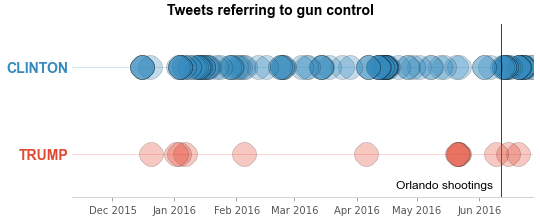

In [138]:
fig,ax = create_standard_figure2(HC,'guncontrol','#348ABD')
titlestring="Tweets referring to gun control"
plt.annotate(titlestring,
                 xy=(0.5,.95),xycoords='figure fraction', 
                size=14,color='black',fontweight="bold",
                horizontalalignment='center', verticalalignment='center',**hfont)
plt.plot(['2016-06-12','2016-06-12'], [0, 2], color='black', linestyle='-', linewidth=.75)

plt.annotate('Orlando shootings', xy=('2016-06-08',1-.009),horizontalalignment='right', textcoords='data',size=12,color='black',**hfont) 


plot_date(DT['created_at'], DT['guncontrol']-.005,color='#E24A33',alpha=.3,markersize=24)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
fig.savefig('guncontrol.png',dpi=300)

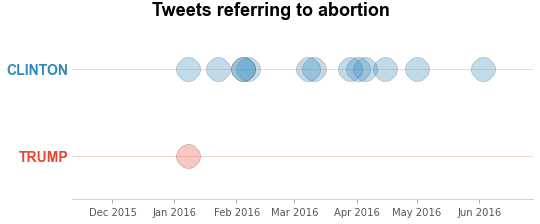

In [139]:
fig,ax = create_standard_figure2(HC,'abortion','#348ABD')
titlestring="Tweets referring to abortion"
plt.annotate(titlestring,
                 xy=(0.5,.95),xycoords='figure fraction', 
                size=18,color='black',fontweight="bold",
                horizontalalignment='center', verticalalignment='center',**hfont)
#plt.plot(['2016-06-12','2016-06-12'], [0, 2], color='grey', linestyle='-', linewidth=.75)
#plt.annotate('Orlando shootings', xy=('2016-06-08',1-.009),horizontalalignment='right', textcoords='data',size=12,color='gray',**hfont) 

plot_date(DT['created_at'], DT['abortion']-.005,color='#E24A33',alpha=.3,markersize=24)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
fig.savefig('abortion.png',dpi=300)

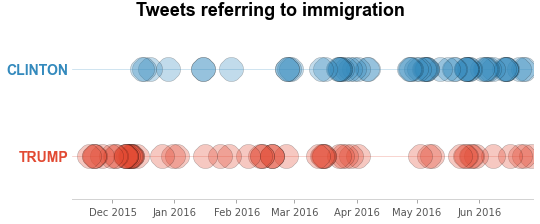

In [140]:
fig,ax = create_standard_figure2(HC,'immigration','#348ABD')
titlestring="Tweets referring to immigration"
plt.annotate(titlestring,
                 xy=(0.5,.95),xycoords='figure fraction', 
                size=18,color='black',fontweight="bold",
                horizontalalignment='center', verticalalignment='center',**hfont)

plot_date(DT['created_at'], DT['immigration']-.005,color='#E24A33',alpha=.3,markersize=24)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
fig.savefig('immigration.png',dpi=300)

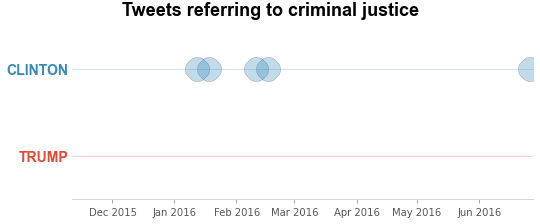

In [141]:
fig,ax = create_standard_figure2(HC,'criminal_justice','#348ABD')
titlestring="Tweets referring to criminal justice"
plt.annotate(titlestring,
                 xy=(0.5,.95),xycoords='figure fraction', 
                size=18,color='black',fontweight="bold",
                horizontalalignment='center', verticalalignment='center',**hfont)

plot_date(DT['created_at'], DT['criminal_justice']-.005,color='#E24A33',alpha=.3,markersize=24)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
fig.savefig('criminal_justice.png',dpi=300)

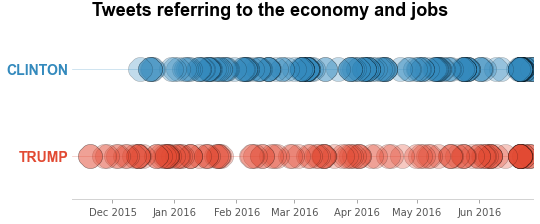

In [142]:
fig,ax = create_standard_figure2(HC,'money','#348ABD')
titlestring="Tweets referring to the economy and jobs"
plt.annotate(titlestring,
                 xy=(0.5,.95),xycoords='figure fraction', 
                size=18,color='black',fontweight="bold",
                horizontalalignment='center', verticalalignment='center',**hfont)

plot_date(DT['created_at'], DT['money']-.005,color='#E24A33',alpha=.3,markersize=24)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
fig.savefig('money.png',dpi=300)

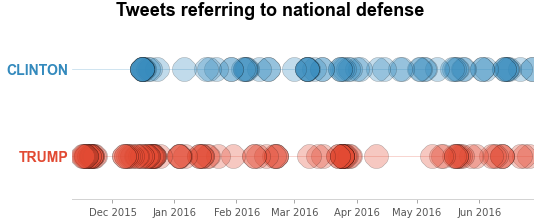

In [143]:
fig,ax = create_standard_figure2(HC,'national_defense','#348ABD')
titlestring="Tweets referring to national defense"
plt.annotate(titlestring,
                 xy=(0.5,.95),xycoords='figure fraction', 
                size=18,color='black',fontweight="bold",
                horizontalalignment='center', verticalalignment='center',**hfont)

plot_date(DT['created_at'], DT['national_defense']-.005,color='#E24A33',alpha=.3,markersize=24)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
fig.savefig('national_defense.png',dpi=300)

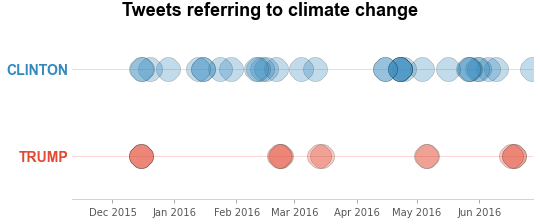

In [144]:
fig,ax = create_standard_figure2(HC,'climate_change','#348ABD')
titlestring="Tweets referring to climate change"
plt.annotate(titlestring,
                 xy=(0.5,.95),xycoords='figure fraction', 
                size=18,color='black',fontweight="bold",
                horizontalalignment='center', verticalalignment='center',**hfont)

plot_date(DT['created_at'], DT['climate_change']-.005,color='#E24A33',alpha=.3,markersize=24)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
fig.savefig('climate_change.png',dpi=300)

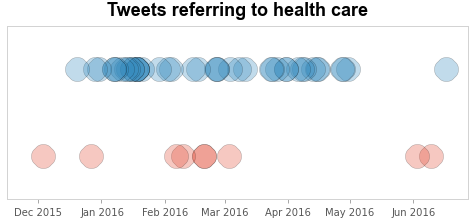

In [85]:
fig,ax = create_standard_figure2(HC,'health_care','#348ABD')
titlestring="Tweets referring to health care"
plt.annotate(titlestring,
                 xy=(0.5,.95),xycoords='figure fraction', 
                size=18,color='black',fontweight="bold",
                horizontalalignment='center', verticalalignment='center',**hfont)

plot_date(DT['created_at'], DT['health_care']-.005,color='#E24A33',alpha=.3,markersize=24)
fig.savefig('health_care.png',dpi=300)

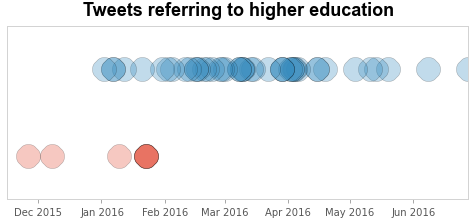

In [86]:
fig,ax = create_standard_figure2(HC,'higher_education','#348ABD')
titlestring="Tweets referring to higher education"
plt.annotate(titlestring,
                 xy=(0.5,.95),xycoords='figure fraction', 
                size=18,color='black',fontweight="bold",
                horizontalalignment='center', verticalalignment='center',**hfont)

plot_date(DT['created_at'], DT['higher_education']-.005,color='#E24A33',alpha=.3,markersize=24)
fig.savefig('higher_education.png',dpi=300)

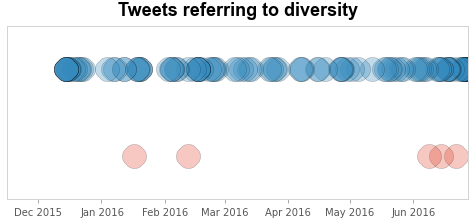

In [87]:
fig,ax = create_standard_figure2(HC,'diversity','#348ABD')
titlestring="Tweets referring to diversity"
plt.annotate(titlestring,
                 xy=(0.5,.95),xycoords='figure fraction', 
                size=18,color='black',fontweight="bold",
                horizontalalignment='center', verticalalignment='center',**hfont)

plot_date(DT['created_at'], DT['diversity']-.005,color='#E24A33',alpha=.3,markersize=24)
fig.savefig('diversity.png',dpi=300)

In [50]:
DT[DT['guncontrol']==1].text

77      When I said that if, within the Orlando club, ...
114     I will be meeting with the NRA, who has endors...
174     Crooked Hillary Clinton will be a disaster on ...
364     Crooked Hillary said that I  want guns brought...
370     "@RBacliff: Hillary wants to rip the guns out ...
371     Crooked Hillary wants to get rid of all guns a...
374     Crooked Hillary Clinton wants to essentially a...
856     "@roadsho: Challenge to all WI gun owners. Vot...
1798    Politicians are trying to chip away at the 2nd...
2261    "@Kacee50: @realDonaldTrump Women make up the ...
2297    Hillary said that guns don't keep you safe. If...
2325    Well, the year has officially begun. I have ma...
2535    "@twister2445: @realDonaldTrump all I heard fr...
Name: text, dtype: object

In [105]:
def n_grams(tweets, n=1):
    
    bigram_vectorizer = CountVectorizer(ngram_range=(n,n),token_pattern=r'\b\w+\b', min_df=1)
    X_2 = bigram_vectorizer.fit_transform(tweets)
    freqs = [(word, X_2.getcol(idx).sum()) for word, idx in bigram_vectorizer.vocabulary_.items()]
    #sort from largest to smallest
    ngramlist = sorted (freqs, key = lambda x: -x[1])
    return ngramlist[:30]

def n_grams_sw(tweets, n=1):
    
    bigram_vectorizer = CountVectorizer(ngram_range=(n,n),token_pattern=r'\b\w+\b',stop_words='english')
    X_2 = bigram_vectorizer.fit_transform(tweets)
    freqs = [(word, X_2.getcol(idx).sum()) for word, idx in bigram_vectorizer.vocabulary_.items()]
    #sort from largest to smallest
    ngramlist = sorted (freqs, key = lambda x: -x[1])
    return ngramlist[:30]

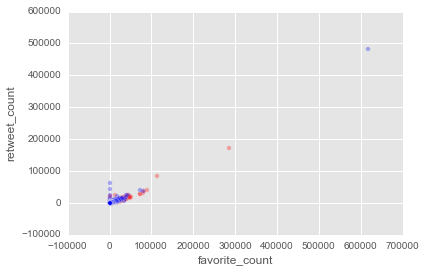

In [265]:
plt.figure()
ax = DT.plot.scatter(x='favorite_count',y='retweet_count',alpha=0.3,color='red')
HC.plot.scatter(x='favorite_count',y='retweet_count',alpha=0.3,color='blue',ax=ax)

In [267]:
DT.head(1)

,text,favorite_count,retweet_count,created_at,speaker,hour,day,char_length,word_length,etext
0,.@CNN is all negative when it comes to me. I d...,12505,3614,2016-06-27 13:39:12,DT,13,0,68,14,. is all negative when it comes to me. I don't...


In [274]:
# define a pipeline combining a text feature extractor with a simple
# classifier
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier()),
])

parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    #'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2),(1,3),(1,4)),  # unigrams or bigrams
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    'clf__n_iter': (10, 50, 80),
}

X = HCDF['etext']
y = HCDF['speaker']

cv = StratifiedShuffleSplit(y, n_iter=5, test_size=0.2, random_state=42)
grid = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=cv)
grid.fit(X, y)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed: 22.2min finished


The best parameters are {'vect__ngram_range': (1, 2), 'vect__max_df': 1.0, 'clf__n_iter': 80, 'tfidf__use_idf': True, 'tfidf__norm': 'l2', 'clf__penalty': 'l2', 'clf__alpha': 1e-05} with a score of 0.92


In [443]:
print grid.predict(['I am the only one who can save the country'])
print grid.predict(['good'])

['DT']
['DT']


In [326]:
print grid.predict(['why do you pay your taxes but doesn"t?? watch  new video with @moveon'])

['DT']


In [320]:
pickle.dump(grid, open('DTHC_predictor.p', 'wb'))

In [542]:
HC.head(2)

,text,favorite_count,retweet_count,created_at,speaker,hour,day,char_length,word_length,etext,guns,abortion,immigration,money,nationaldefense,climatechange,healthcare,highereducation,diversity
0,A great day to hit the campaign trail in Ohio ...,2147,685,2016-06-27 17:18:25,HC,17,0,91,13,A great day to hit the campaign trail in Ohio ...,0,0,0,0,0,0,0,0,0
1,"""Hillary believes that racism, hatred, injusti...",2984,1155,2016-06-27 16:04:36,HC,16,0,133,15,"""Hillary believes that racism, hatred, injusti...",0,0,0,0,0,0,0,0,1


In [515]:
HC['diversity']=HC_diversity
DT['diversity']=DT_diversity
HC['guns']=HC_guns
DT['guns']=DT_guns
HC['abortion']=HC_abortion
DT['abortion']=DT_abortion
HC['immigration']=HC_immigration
DT['immigration']=DT_immigration
HC['money']=HC_money
DT['money']=DT_money
HC['nationaldefense']=HC_nationaldefense
DT['nationaldefense']=DT_nationaldefense
HC['climatechange']=HC_climatechange
DT['climatechange']=DT_climatechange
HC['healthcare']=HC_healthcare
DT['healthcare']=DT_healthcare
HC['highereducation']=HC_highereducation
DT['highereducation']=DT_highereducation

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [453]:
for t in HC['etext']:
    if 'gun' in t:
        print t

Not even a sit-in in Congress could convince Republican leadership to move forward on gun violence prevention. Americans deserve better.
No person should be gunned down while learning, teaching, praying, or dancing. It's time for us to come together to strengthen our gun laws.
Thank you, #DemocraticSitIn. Your determination has exposed Republican inaction on gun violence and demanded better. We can't give up. -H
  . we will not leave without acting for the victims &amp; families of reckless gun violence. #NoBillNoBreak 
  Rather than debate &amp; vote on common sense gun safety legislation,  has sent House home early for July 4 holiday…
  This is what the #gunviolence #sitin looks like frm where I'm sitting #AsLongAsItTakes #NoBillNoBreak #NoMoreSilence 
  . want to know a more effective way to end this sit-in? Let us vote our consciences on gun legislation! #NoBil…
House Republicans may have cut the cameras, but they can't cut off our voices. We have to act on gun violence. -H 
An ove

In [341]:
X = HCDF[['hour','day','char_length','word_length']]
y = HCDF['retweet_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
rng = np.random.RandomState(1)
# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=4)

regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=300, random_state=rng)

regr_1.fit(X_train, y_train)
regr_2.fit(X_train, y_train)

# Predict
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

#print regr.score(X_test,y_test)

In [343]:
print regr_1.score(X_test,y_test)
print regr_2.score(X_test, y_test)

0.0090506876094
-0.101064820813


In [399]:
HC.sort_values('favorite_count',ascending=False)[['text','favorite_count']].head(10)

,text,favorite_count
310,Delete your account. https://t.co/Oa92sncRQY,618368
180,Hi. https://t.co/11Fyyf5IQm,79865
356,"To every little girl who dreams big: Yes, you ...",73657
85,"You*\n\n*offer not valid for Muslims, women, L...",42931
1729,#GOPdebate https://t.co/SGW200luN8,39226
1723,Marriage equality is the law of the land. Deal...,38378
262,Woke up to hear the devastating news from FL. ...,35833
349,"For the first time in our history, a woman wil...",34700
158,"What a joy being with our new grandson, Aidan....",33851
1722,How many more of these do we have to sit throu...,30822


In [402]:
HC.iloc[349]['text']

u'For the first time in our history, a woman will be a major party\u2019s nominee for President of the United States. https://t.co/4iLojpuPj8'

In [403]:
DT.sort_values('favorite_count',ascending=False)[['text','favorite_count']].head(10)

,text,favorite_count
171,How long did it take your staff of 823 people ...,285060
579,Happy #CincoDeMayo! The best taco bowls are ma...,112958
140,Is President Obama going to finally mention th...,90429
173,Obama just endorsed Crooked Hillary. He wants ...,82745
142,Horrific incident in FL. Praying for all the v...,79016
141,Appreciate the congrats for being right on rad...,73746
137,What has happened in Orlando is just the begin...,73377
121,Thank you to the LGBT community! I will fight ...,51728
122,AMERICA FIRST!,48666
114,"I will be meeting with the NRA, who has endors...",47770


In [409]:
DT.iloc[114]['text']

u'I will be meeting with the NRA, who has endorsed me, about not allowing people on the terrorist watch list, or the no fly list, to buy guns.'

In [346]:
mexico = r'[mM]ex|[lL]atin'
islam = r'[Ii]slam|[Mm]uslim'

In [436]:
job=[]
for s in HC['text']:
    if re.search('job|employment',s):
        job.append(1)
    else:
        job.append(0)


In [437]:
print HC.shape
print len(job)

(3224, 10)
3224


In [438]:
HCissues=pd.DataFrame()
HCissues['date']=HC['created_at']
HCissues['jobs']=job

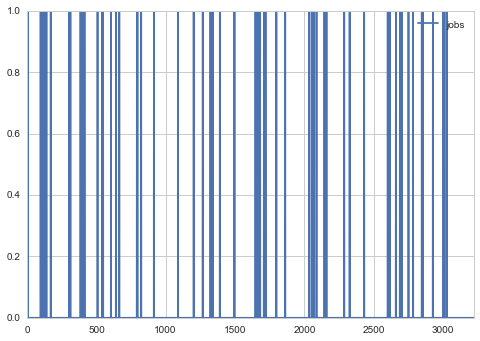

In [441]:
HCissues.plot()

In [356]:
def n_grams_topic(tweets, n=1,topic=''):
    
    bigram_vectorizer = CountVectorizer(ngram_range=(n,n),token_pattern=r'\b\w+\b', min_df=1)
    X_2 = bigram_vectorizer.fit_transform(tweets)
    freqs = [(word, X_2.getcol(idx).sum()) for word, idx in bigram_vectorizer.vocabulary_.items() if re.search(topic,word)]
    #sort from largest to smallest
    ngramlist = sorted (freqs, key = lambda x: -x[1])
    return ngramlist[:30]

In [362]:
HC_2_grams_islam = n_grams_topic(HCtweets, n=10,topic=mexico)
HC_2_grams_islam[0:20]

[(u'es hoy env a latinos al 47246 para que hillary', 1),
 (u'as immigrants as latinos to really put our imprint on', 1),
 (u'intensifying his bigoted attacks on judge curiel s latino heritage', 1),
 (u'be disqualified from his job because of his mexican heritage', 1),
 (u'oppounity as immigrants as latinos to really put our imprint', 1),
 (u'comments about a latino judge are so disgusting even other', 1),
 (u'latino judge are so disgusting even other republicans are offended', 1),
 (u'a great oppounity as immigrants as latinos to really put', 1),
 (u'latinos to really put our imprint on the election hill', 1),
 (u'is campaigning on immigration reform amp suppoing latinos fine but', 1),
 (u'pagar la renta y las familias latinas y afroamericanas son', 1),
 (u'trump empez su campa a diciendo que los mexicanos son', 1),
 (u'mexicanos son violadores y traen drogas y crimen no se', 1),
 (u'amp suppoing latinos fine but he should explain his spotty', 1),
 (u'you re black or latino that has to

In [361]:
DT_2_grams_islam = n_grams_topic(DTtweets, n=10,topic=mexico)
DT_2_grams_islam[0:20]

[(u'america 2 000 being eliminated for move to mexico via', 1),
 (u'to mexico now losing ford and many others kasich is', 1),
 (u'trump on ford carrier shipping jobs to mexico i m', 1),
 (u'new mexico amazing crowd now in l a big rally', 1),
 (u'we must build a great wall between mexico and the', 1),
 (u'illegal immigrant children non mexicans surge across border at record', 1),
 (u'must build a great wall between mexico and the united', 1),
 (u'the protesters in new mexico were thugs who were flying', 1),
 (u'mexico etc no more if i win we will bring', 1),
 (u'and china on trade and mexico at the border bad', 1),
 (u'to mexico i m the only one who understands what', 1),
 (u'2 000 being eliminated for move to mexico via haford', 1),
 (u'who were flying the mexican flag the rally inside was', 1),
 (u'lost 400 000 since 2000 going to mexico etc no', 1),
 (u'isis and china on trade and mexico at the border', 1),
 (u'a wall a great wall and mexico is going to', 1),
 (u'donald trump no we r

In [381]:
DT_1grams_sw = n_grams_sw(DTtweets, n=1)
DT_1grams_sw

[(u'trump', 514),
 (u'great', 492),
 (u'thank', 489),
 (u'trump2016', 451),
 (u't', 328),
 (u's', 320),
 (u'makeamericagreatagain', 306),
 (u'amp', 296),
 (u'just', 244),
 (u'america', 241),
 (u'hillary', 227),
 (u'new', 222),
 (u'cruz', 222),
 (u'people', 215),
 (u'make', 165),
 (u'big', 156),
 (u'poll', 151),
 (u'ted', 138),
 (u'like', 130),
 (u'vote', 125),
 (u'president', 120),
 (u'tonight', 111),
 (u'donald', 110),
 (u'time', 104),
 (u'iowa', 100),
 (u'clinton', 99),
 (u'rubio', 98),
 (u'm', 94),
 (u'said', 94),
 (u'today', 90)]

In [380]:
HC_1grams_sw = n_grams_sw(HCtweets, n=1)
HC_1grams_sw

[(u's', 1004),
 (u'hillary', 790),
 (u't', 410),
 (u'trump', 311),
 (u'president', 258),
 (u'need', 231),
 (u'h', 203),
 (u'demdebate', 180),
 (u'women', 179),
 (u'make', 174),
 (u'let', 164),
 (u'families', 161),
 (u'america', 159),
 (u'just', 143),
 (u'today', 142),
 (u'donald', 139),
 (u'people', 134),
 (u'imwithher', 132),
 (u'americans', 129),
 (u'new', 124),
 (u've', 122),
 (u'amp', 117),
 (u'rights', 112),
 (u'gopdebate', 109),
 (u'vote', 107),
 (u'care', 103),
 (u'country', 98),
 (u'health', 98),
 (u'gun', 96),
 (u'time', 95)]

In [153]:
HC_2grams_sw = n_grams_sw(HCtweets, n=2)
HC_2grams_sw[0:20]

[(u'donald trump', 133),
 (u'hillary s', 92),
 (u'let s', 81),
 (u'don t', 64),
 (u'trump s', 60),
 (u'isn t', 60),
 (u'hillary clinton', 55),
 (u'health care', 54),
 (u'women s', 46),
 (u'gun violence', 43),
 (u's time', 38),
 (u've got', 37),
 (u'new hampshire', 36),
 (u'white house', 36),
 (u'shouldn t', 33),
 (u'make sure', 31),
 (u'supreme cou', 31),
 (u'doesn t', 30),
 (u'new york', 30),
 (u't let', 29)]

In [154]:
HC_2grams = n_grams(HCtweets, n=2)
HC_2grams[0:20]

[(u'it s', 192),
 (u'we need', 166),
 (u'we can', 155),
 (u'if you', 139),
 (u'donald trump', 133),
 (u'can t', 126),
 (u'of the', 115),
 (u'need to', 109),
 (u'on the', 106),
 (u'in the', 106),
 (u'you re', 105),
 (u'to be', 102),
 (u'we re', 101),
 (u'to the', 92),
 (u'have to', 87),
 (u'hillary s', 86),
 (u'let s', 81),
 (u'to make', 77),
 (u'we ve', 74),
 (u'i m', 71)]

In [155]:
HC_3grams = n_grams(HCtweets, n=3)
HC_3grams[0:20]

[(u'we need to', 83),
 (u'we can t', 81),
 (u'if you re', 48),
 (u'we have to', 40),
 (u'we need a', 40),
 (u'to 47246 to', 37),
 (u'it s time', 36),
 (u'the white house', 36),
 (u'a president who', 34),
 (u'if you agree', 31),
 (u'we ve got', 27),
 (u'need a president', 27),
 (u'donald trump is', 27),
 (u'can t afford', 25),
 (u's time to', 24),
 (u'you re with', 24),
 (u'here s what', 23),
 (u've got to', 23),
 (u'commander in chief', 22),
 (u'it s not', 21)]

In [156]:
HC_4grams = n_grams(HCtweets, n=4)
HC_4grams[0:20]

[(u'need a president who', 25),
 (u'we can t afford', 24),
 (u'it s time to', 24),
 (u'we ve got to', 23),
 (u'we need a president', 23),
 (u'we can t let', 21),
 (u'the progress we ve', 19),
 (u'we re going to', 19),
 (u'progress we ve made', 19),
 (u'a president who will', 18),
 (u'in the white house', 14),
 (u'to tell hillary you', 13),
 (u'you re with hillary', 13),
 (u'47246 to find your', 12),
 (u'if you re with', 12),
 (u'the affordable care act', 12),
 (u'to 47246 to find', 12),
 (u'to the white house', 11),
 (u'tell hillary you re', 11),
 (u'your name if you', 11)]

In [157]:
HC_5grams = n_grams(HCtweets, n=5)
HC_5grams[0:20]

[(u'we need a president who', 21),
 (u'the progress we ve made', 19),
 (u'need a president who will', 15),
 (u'to 47246 to find your', 12),
 (u'to tell hillary you re', 11),
 (u'47246 to tell hillary you', 11),
 (u'add your name if you', 11),
 (u'to 47246 to tell hillary', 11),
 (u'to be commander in chief', 10),
 (u'if you re with hillary', 9),
 (u'your name if you agree', 9),
 (u'text where to 47246 to', 9),
 (u'on the progress we ve', 9),
 (u'where to 47246 to find', 9),
 (u'we can t afford a', 9),
 (u'to find your polling place', 9),
 (u'all the way to the', 9),
 (u'the way to the white', 9),
 (u'way to the white house', 9),
 (u'47246 to find your polling', 9)]

In [85]:
DT_bigrams = n_grams(DTtweets, n=2)

In [158]:
DT_2grams_sw = n_grams_sw(DTtweets, n=2)
DT_2grams_sw[0:20]

[(u'makeamericagreatagain trump2016', 137),
 (u'make america', 122),
 (u'america great', 111),
 (u'ted cruz', 109),
 (u'donald trump', 84),
 (u'hillary clinton', 76),
 (u'crooked hillary', 74),
 (u'don t', 71),
 (u'new hampshire', 60),
 (u'south carolina', 59),
 (u'doesn t', 50),
 (u'u s', 50),
 (u'trump2016 makeamericagreatagain', 46),
 (u'new york', 42),
 (u'marco rubio', 40),
 (u'lyin ted', 37),
 (u'mr trump', 37),
 (u'didn t', 37),
 (u'beat hillary', 29),
 (u'won t', 28)]

In [86]:
DT_bigrams[0:20]

[(u'thank you', 475),
 (u'will be', 271),
 (u'i will', 191),
 (u'of the', 177),
 (u'makeamericagreatagain trump2016', 137),
 (u'in the', 129),
 (u'make america', 122),
 (u'great again', 121),
 (u'i am', 116),
 (u'is a', 116),
 (u'america great', 111),
 (u'ted cruz', 109),
 (u'for the', 92),
 (u'donald trump', 84),
 (u'a great', 81),
 (u'hillary clinton', 76),
 (u'crooked hillary', 74),
 (u'you for', 74),
 (u'to be', 71),
 (u'don t', 71)]

In [159]:
DT_trigrams = n_grams(DTtweets, n=3)
DT_trigrams[0:20]

[(u'make america great', 111),
 (u'i will be', 111),
 (u'america great again', 110),
 (u'thank you for', 73),
 (u'will be interviewed', 52),
 (u'be interviewed on', 39),
 (u'will be on', 34),
 (u'you for your', 33),
 (u'crooked hillary clinton', 32),
 (u'will make america', 28),
 (u'all of the', 26),
 (u'lyin ted cruz', 24),
 (u'thank you to', 23),
 (u'the u s', 23),
 (u'the people of', 22),
 (u'thank you america', 22),
 (u'thank you trump2016', 22),
 (u'one of the', 22),
 (u'we will make', 21),
 (u'in new hampshire', 20)]

In [160]:
DT_quadgrams = n_grams(DTtweets, n=4)
DT_quadgrams[0:20]

[(u'make america great again', 110),
 (u'will be interviewed on', 39),
 (u'i will be interviewed', 38),
 (u'thank you for your', 33),
 (u'i will be on', 24),
 (u'will make america great', 21),
 (u'we will make america', 20),
 (u'be interviewed on at', 19),
 (u'thank you for the', 18),
 (u'you for your suppo', 17),
 (u'will be interviewed by', 12),
 (u'i am the only', 12),
 (u'thank you america trump2016', 12),
 (u'self funding my campaign', 11),
 (u'to make america great', 11),
 (u'thank you makeamericagreatagain trump2016', 11),
 (u'interviewed on at 7', 10),
 (u'weak on illegal immigration', 10),
 (u'i will beat hillary', 10),
 (u'i will be in', 10)]

In [104]:
for t in HCtweets:
    if 'need a president who' in t:
        print t

We need a president who's fighting to raise incomes for all Americans, not one who tries to profit at their expense. 
We need a president who will unite leaders around the world to defeat ISIS, not one who insults and alienates them. 
We need a president who will take action on gun violence and stand with victims' families against the gun lobby.

We need a president who will always put families above the gun lobby. #DemDebate

We need a president who can bring people together.

Hate and bigotry have no place in America.

We need a president who doesn’t just rail against trade. We need a president who knows how to compete against the rest of the world and win.
"We need a president who will help break down all the barriers holding Americans back, not just some." -Hillary
We need a president who will make comprehensive immigration reform a top priority and keep families together. 
We need a president who will provide leadership that’s strong, sma, and steady. The last thing we need are le

In [110]:
for t in DTtweets:
    if 'I am the only' in t:
        print t

Remember, I am the only candidate who is self-funding. While I am given little credit for this by the voters, I am not bought like others!
Remember, I am the only one who is self-funding my campaign. All of the other candidates are bought and paid for by special interests!
It was great being in Michigan. Remember, I am the only presidential candidate who will bring jobs back to the U.S.and protect car industry!
For all of today's voters please remember that I am the only candidate that is self funding my campaign, I am not bought and paid for!
I am the only one who can beat Hillary Clinton. I am not a Mitt Romney, who doesn't know how to win. Hillary wants no pa of "Trump"
I am the only Republican who will get large numbers of Dems and Indies (crossover). I will also get states that no other Republican can get.
I am the only candidate (in many years) who is self-funding his campaign. Lobbyists and $ interests totally control all other candidates!
Remember, Cruz and Bush gave us Robes w

In [111]:
#weak on illegal immigration
for t in DTtweets:
    if 'weak on illegal immigration' in t:
        print t

Ohio is losing jobs to Mexico, now losing Ford (and many others). Kasich is weak on illegal immigration. We need strong borders now!
Rubio is weak on illegal immigration, with the worst voting record in the U.S. Senate in many years. He will never MAKE AMERICA GREAT AGAIN!
Ted Cruz only talks tough on immigration now because he did so badly in S.C. He is in favor of amnesty and weak on illegal immigration.
Remember that Marco Rubio is very weak on illegal immigration. South Carolina needs strength as illegals and Syrians pour in. Don't allow it
"  is really staing to campaign hard for marcorubio. #fairandbalancedmyass"  He is weak on illegal immigration!
Jeb Bush is desperate - strongly in favor of #CommonCore and very weak on illegal immigration.
Hillary Clinton is weak on illegal immigration, among many other things. She is strong on corruption - corruption is what she's best at!
. is weak on illegal immigration &amp; totally incompetent as a manager and leader - no strength or stami

In [383]:
sum(1 for t in HCtweets if 'bad' in t)

5

In [386]:
sum(1 for t in HCtweets if 'good' in t)

37

In [384]:
sum(1 for t in DTtweets if 'bad' in t)

79

In [385]:
sum(1 for t in DTtweets if 'good' in t)

60

In [387]:
sum(1 for t in DTtweets if 'great' in t)

265

In [388]:
sum(1 for t in HCtweets if 'great' in t)

48

In [417]:
HC[r'[Mm]usl|[iI]slam', x) for x in HC['text']]]

KeyError: '[None None None ..., None None None] not in index'